# Python Imports

In [ ]:
import os
import mimetypes
from google import genai
from google.genai import types
from PIL import Image
from dotenv import load_dotenv
from IPython.display import Image, display

# Loading Credentials from `.env`

In [46]:
load_dotenv(dotenv_path=".env", override=True)

API_KEY = os.environ.get("GEMINI_API_KEY", "")

# Initialize the client (Gemini Developer API)
client = genai.Client(api_key=API_KEY)

model = "gemini-2.5-flash-image-preview"

# Read multiple local images as bytes

In [47]:
image_paths = ["./virtual-try-on/blue-dress.jpg", "./virtual-try-on/female-model.png"]  # First: dress, Second: model
image_parts = []
for i, image_path in enumerate(image_paths, start=1):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")
    with open(image_path, "rb") as f:
        image_bytes = f.read()
    mime_type, _ = mimetypes.guess_type(image_path)
    if mime_type is None:
        mime_type = "image/jpeg" if image_path.lower().endswith('.jpg') else "image/png"
    image_parts.append(types.Part.from_bytes(data=image_bytes, mime_type=mime_type))

# Display `image_parts`

In [48]:
image_parts

[Part(
   inline_data=Blob(
     data=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xe2\x01\xd8ICC_PROFILE\x00\x01\x01\x00\x00\x01\xc8\x00\x00\x00\x00\x040\x00\x00mntrRGB XYZ \x07\xe0\x00\x01\x00\x01\x00\x00\x00\x00\x00\x00acsp\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...',
     mime_type='image/jpeg'
   )
 ),
 Part(
   inline_data=Blob(
     data=b"\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03\x80\x00\x00\x04\x80\x08\x02\x00\x00\x00!\xf1\xb4\x8e\x00\x00\x00\tpHYs\x00\x00\x00\x01\x00\x00\x00\x01\x00O%\xc4\xd6\x00\x00\x10\x00IDATx\x9ct\xbd\xf7W\x14Y\xd7\xfe}\xff\xf0~\xef1'\x82\x18\xc9\x99nr\xceYQ\t\xa2\x82\x8aD\xc7q\xcc\xa0...',
     mime_type='image/png'
   )
 )]

# Define the content: Prompt references the images explicitly

In [49]:
prompt = """Create a professional e-commerce fashion photo. 
            Take the blue dress from the first image and let the woman from the second image wear it.
            Generate a realistic, full-body shot of the woman wearing the dress. 
            Ensure the woman's face, her pose, and dress design and features remain completely unchanged."""


contents = [
        types.Content(
            role="user",
            parts=[
                types.Part.from_text(text=prompt),
                image_parts[0],  # First image: dress
                image_parts[1],  # Second image: model
            ]
        )
    ]

# Display `contents`

In [50]:
contents

[Content(
   parts=[
     Part(
       text="""Create a professional e-commerce fashion photo. 
             Take the blue dress from the first image and let the woman from the second image wear it.
             Generate a realistic, full-body shot of the woman wearing the dress. 
             Ensure the woman's face, her pose, and dress design and features remain completely unchanged."""
     ),
     Part(
       inline_data=Blob(
         data=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xe2\x01\xd8ICC_PROFILE\x00\x01\x01\x00\x00\x01\xc8\x00\x00\x00\x00\x040\x00\x00mntrRGB XYZ \x07\xe0\x00\x01\x00\x01\x00\x00\x00\x00\x00\x00acsp\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...',
         mime_type='image/jpeg'
       )
     ),
     Part(
       inline_data=Blob(
         data=b"\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03\x80\x00\x00\x04\x80\x08\x02\x00\x00\x00!\xf1\xb4\x8e\x00\x00\x00\tpHYs\x00\x00\x00\x01\x00\x00\x00\x0

# Plain dictionary config (no Pydantic)

In [51]:

generate_content_config = {
    "response_modalities": ["TEXT", "IMAGE"],  # Generate both text and image
    # "temperature": 0.7,  # Adjust for creativity (0-1)
    # "max_output_tokens": 200,  # Limit text length
}

# Generate content (synchronous non-streaming)

In [52]:
response = client.models.generate_content(
    model=model,
    contents=contents,
    config=generate_content_config,
)

# Display Response

In [53]:
response

GenerateContentResponse(
  automatic_function_calling_history=[],
  candidates=[
    Candidate(
      content=Content(
        parts=[
          Part(
            text='Here is the e-commerce fashion photo you requested: '
          ),
          Part(
            inline_data=Blob(
              data=<... Max depth ...>,
              mime_type=<... Max depth ...>
            )
          ),
        ],
        role='model'
      ),
      finish_reason=<FinishReason.STOP: 'STOP'>,
      index=0
    ),
  ],
  model_version='gemini-2.5-flash-image-preview',
  response_id='4XfCaIvGB4zhz7IPqMO6-QI',
  sdk_http_response=HttpResponse(
    headers=<dict len=11>
  ),
  usage_metadata=GenerateContentResponseUsageMetadata(
    candidates_token_count=1302,
    candidates_tokens_details=[
      ModalityTokenCount(
        modality=<MediaModality.IMAGE: 'IMAGE'>,
        token_count=1290
      ),
    ],
    prompt_token_count=2651,
    prompt_tokens_details=[
      ModalityTokenCount(
        modality

# Handle the response if its has text

In [54]:
if response.text:
    print("Generated Text:")
    print(response.text)

Generated Text:
Here is the e-commerce fashion photo you requested: 


# Handle generated image (if present) save and display it


Generated Image saved to: ./generated-images/model_wearing_dress.png


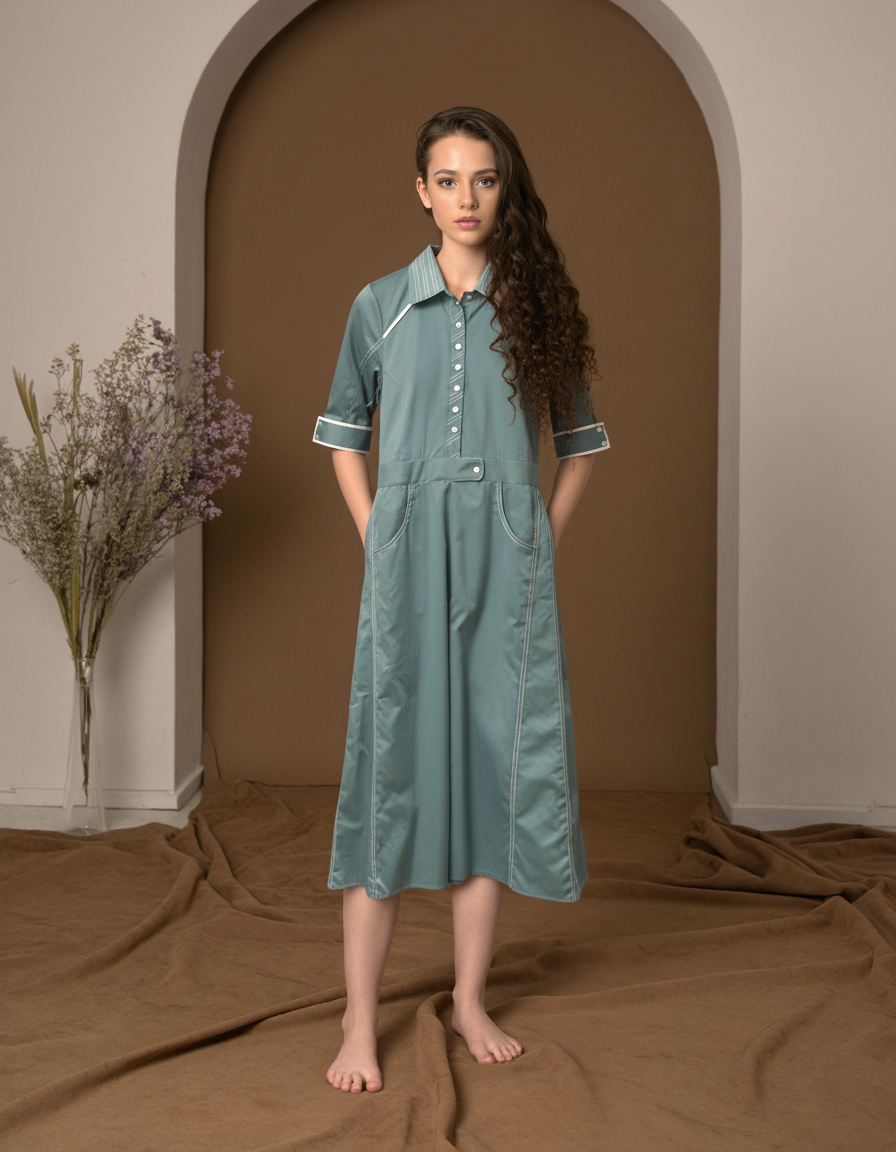

In [58]:
image_found = False
output_file = ""
for part in response.candidates[0].content.parts:
    if hasattr(part, "inline_data") and part.inline_data and part.inline_data.data:
        image_found = True
        mime_type = part.inline_data.mime_type
        data_buffer = part.inline_data.data  # Binary blob data
        file_extension = mimetypes.guess_extension(mime_type) or ".png"
        output_file = f"./generated-images/model_wearing_dress{file_extension}"
        with open(output_file, "wb") as f:
            f.write(data_buffer)
        print(f"\nGenerated Image saved to: {output_file}")
        break
if not image_found:
    print("\nNo image generated in this response.")

if image_found and output_file:
    display(Image(filename=output_file))

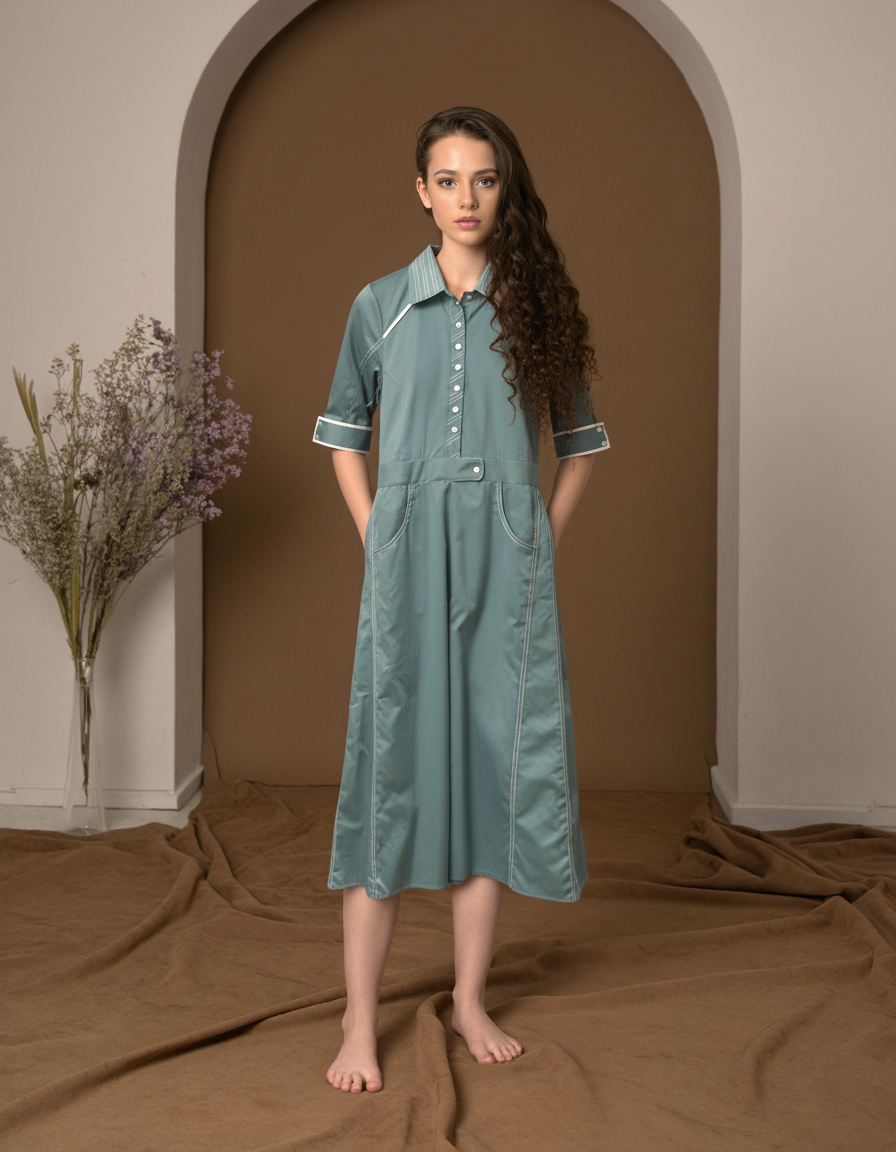